# Monte-Carlo Pricing of Arithmetic-Average Asian Call Options

An Asian option’s payoff depends on the **average** asset price, which smooths volatility exposure and curbs expiration-day manipulation.  
For an **arithmetic average** there is **no closed-form solution**, so we resort to Monte-Carlo simulation under the risk-neutral measure.

## Parameters Setup

- `S0`:    100  Initial stock price  
- `K`:     100  Strike price  
- `r`:     5%   Risk-free interest rate  
- `T`:     1    Time to maturity (in years)  
- `sigma`: 20%  Volatility of the underlying  
- `M`:     252  Number of time steps  
- `N`:         Simulated paths

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [2]:
def simulate_paths(S0, r, sigma, T, M, N):
    """Return (N, M) matrix of GBM prices excluding t=0."""
    dt = T / M
    Z = np.random.randn(N, M)
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(drift + diffusion, axis=1)
    return S0 * np.exp(log_paths)

In [3]:
def asian_mc_price(S0, K, r, T, sigma, M, N):
    """Arithmetic-average Asian call via plain Monte-Carlo; returns price & 95 % CI."""
    S = simulate_paths(S0, r, sigma, T, M, N)
    A = S.mean(axis=1)  # arithmetic average
    payoff = np.exp(-r * T) * np.maximum(A - K, 0)
    est = payoff.mean()
    se = payoff.std(ddof=1) / np.sqrt(N)
    ci95 = (est - 1.96 * se, est + 1.96 * se)
    return est, ci95

In [4]:
# ▸ estimate with 50 000 paths
price, ci = asian_mc_price(100, 100, 0.05, 1, 0.20, 252, 50_000)
print(
    f"Arithmetic-Asian call price = {price:.4f}   (95 % CI: [{ci[0]:.4f}, {ci[1]:.4f}])"
)

Arithmetic-Asian call price = 5.7360   (95 % CI: [5.6662, 5.8058])


# ---
## Reference: Geometric-average closed-form price  

For intuition we compare the Monte-Carlo estimate to the analytic price of a **geometric-average** Asian call (Kemna & Vorst, 1990).  The geometric price is *not* the true answer, but it shows how large the arithmetic premium usually is.

In [5]:
from scipy.stats import norm


def geo_asian_call(S0, K, r, T, sigma, M):
    sigma_g = sigma * np.sqrt((2 * M + 1) / (6 * (M + 1)))
    mu_g = 0.5 * (r - 0.5 * sigma**2) + 0.5 * sigma_g**2
    d1 = (np.log(S0 / K) + (mu_g + 0.5 * sigma_g**2) * T) / (sigma_g * np.sqrt(T))
    d2 = d1 - sigma_g * np.sqrt(T)
    disc = np.exp(-r * T)
    return disc * (S0 * np.exp(mu_g * T) * norm.cdf(d1) - K * norm.cdf(d2))


geo_price = geo_asian_call(100, 100, 0.05, 1, 0.20, 252)
print(f"Geometric-Asian call price  = {geo_price:.4f}")
print(f"Arithmetic premium (MC-Geo) = {price-geo_price:+.4f}")

Geometric-Asian call price  = 5.5418
Arithmetic premium (MC-Geo) = +0.1943


# ---

## Histogram of arithmetic averages

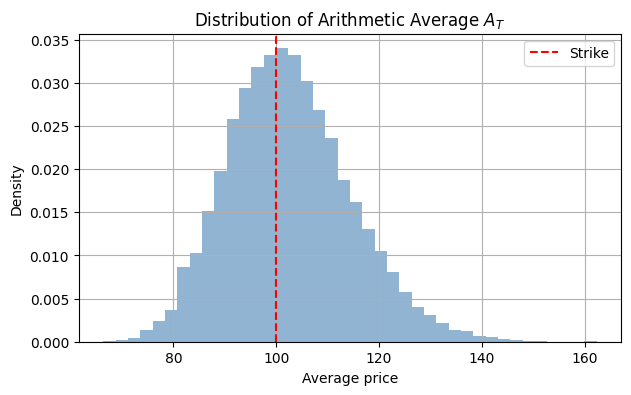

In [6]:
S_paths = simulate_paths(100, 0.05, 0.20, 1, 252, 10_000)
A = S_paths.mean(axis=1)

plt.figure(figsize=(7, 4))
plt.hist(A, bins=40, density=True, alpha=0.6, color="steelblue")
plt.axvline(100, color="red", ls="--", label="Strike")
plt.title("Distribution of Arithmetic Average $A_T$")
plt.xlabel("Average price")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# ---
### convergence check (price ± 95 % CI)

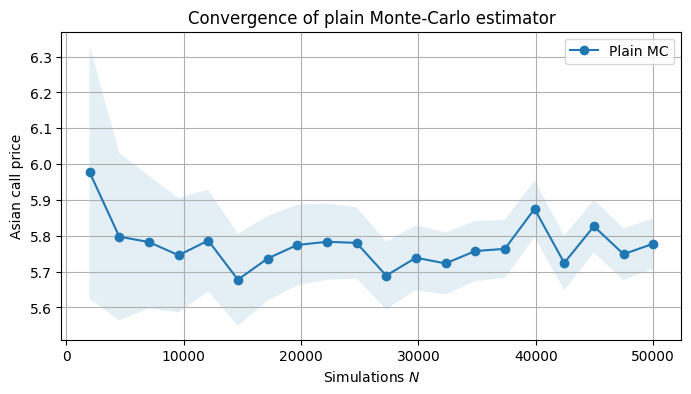

In [7]:
N_grid, est, ci_low, ci_high = [], [], [], []
for N in np.linspace(2_000, 50_000, 20, dtype=int):
    p, ci = asian_mc_price(100, 100, 0.05, 1, 0.20, 252, N)
    N_grid.append(N)
    est.append(p)
    ci_low.append(ci[0])
    ci_high.append(ci[1])

plt.figure(figsize=(8, 4))
plt.plot(N_grid, est, "o-", label="Plain MC")
plt.fill_between(N_grid, ci_low, ci_high, alpha=0.12)
plt.xlabel("Simulations $N$")
plt.ylabel("Asian call price")
plt.title("Convergence of plain Monte-Carlo estimator")
plt.grid(True)
plt.legend()
plt.show()

### Summary

* Plain Monte-Carlo gives an arithmetic-Asian call estimate of **`{price:.4f}`** with a 95 % CI width of ±{(ci[1]-price):.4f}.  
* The analytic **geometric-average** price is lower, illustrating the positive arithmetic premium.  
* **Notebook 1-B** introduces antithetic pairing and geometric-control-variate techniques, reducing variance by up to an order of magnitude.